In [75]:
from sklearn.preprocessing import MinMaxScaler
import math
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

%matplotlib inline
sns.set(color_codes=True)

train = pd.read_csv('data/train.csv')
store = pd.read_csv('data/store.csv')
test = pd.read_csv('data/test.csv')

train.head()

c:\users\tracy\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [76]:
def week_of_year(dt):
    return dt.isocalendar()[1]

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(math.ceil(adjusted_dom/7.0))

def day_of_year(dt):
    return dt.timetuple().tm_yday

def generate_all_features_in_one_column(x):
    year = x.split('-')[0]
    month = x.split('-')[1]
    date = x.split('-')[2]
    dt = datetime.date(int(year), int(month), int(date))
    woy = week_of_year(dt)
    wom = week_of_month(dt)
    doy = day_of_year(dt)
    return "{}-{}-{}-{}-{}-{}".format(year,month,date,woy,wom,doy)

def split_date(df):
    df['Date'] = df['Date'].apply(lambda x: generate_all_features_in_one_column(x))
    df['Year'] = df['Date'].apply(lambda x: x.split('-')[0])
    df['Month'] = df['Date'].apply(lambda x: x.split('-')[1])
    df['Day'] = df['Date'].apply(lambda x: x.split('-')[2])
    #df['WeekOfYear'] = df['Date'].apply(lambda x: x.split('-')[3])
    #df['WeekOfMonth'] = df['Date'].apply(lambda x: x.split('-')[4])
    #df['DayOfYear'] = df['Date'].apply(lambda x: x.split('-')[5])
    df = df.drop(['Date'], axis=1)

    return df

def preprocess_data(df):
    # StateHoliday，处理为不放假 0，放假 1
    df["StateHoliday"] = df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
    df = split_date(df)
    df_day_of_week  = pd.get_dummies(df['DayOfWeek'], prefix='Day')
    df = df.join(df_day_of_week)
    df = df.drop(['DayOfWeek'], axis=1)
    return df


# 训练集-预处理
train = preprocess_data(train)
# 查看训练集合并后的情况
train.head()

,Store,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,DayOfYear,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7
0,1,5263,555,1,1,0,1,2015,07,31,31,212,0,0,0,0,1,0,0
1,2,6064,625,1,1,0,1,2015,07,31,31,212,0,0,0,0,1,0,0
2,3,8314,821,1,1,0,1,2015,07,31,31,212,0,0,0,0,1,0,0
3,4,13995,1498,1,1,0,1,2015,07,31,31,212,0,0,0,0,1,0,0
4,5,4822,559,1,1,0,1,2015,07,31,31,212,0,0,0,0,1,0,0


In [77]:
# 通过drop duplicates发现Open有NaN的值
print(test['Open'].drop_duplicates())
print("===================================================================")
# 打印出Open为空值的那几行数据
index = test['Open'].index[test['Open'].apply(np.isnan)]
print(test.loc[index])
# 分析后发现，那几天都为工作日并且没有放假，所以全部设置为1
test['Open'][index] = 1
print("===================================================================")
# 打印出修改后的数据
print(test.loc[index])

0      1.0
479    NaN
543    0.0
Name: Open, dtype: float64
          Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
479      480    622          4  2015-09-17   NaN      1            0   
1335    1336    622          3  2015-09-16   NaN      1            0   
2191    2192    622          2  2015-09-15   NaN      1            0   
3047    3048    622          1  2015-09-14   NaN      1            0   
4759    4760    622          6  2015-09-12   NaN      0            0   
5615    5616    622          5  2015-09-11   NaN      0            0   
6471    6472    622          4  2015-09-10   NaN      0            0   
7327    7328    622          3  2015-09-09   NaN      0            0   
8183    8184    622          2  2015-09-08   NaN      0            0   
9039    9040    622          1  2015-09-07   NaN      0            0   
10751  10752    622          6  2015-09-05   NaN      0            0   

       SchoolHoliday  
479                0  
1335               0  
2191  

c:\users\tracy\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [78]:
# 训练集-预处理
test = preprocess_data(test)
# 查看训练集合并后的情况
test.head()

,Id,Store,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,DayOfYear,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7
0,1,1,1.0,1,0,0,2015,09,17,38,260,0,0,0,1,0,0,0
1,2,3,1.0,1,0,0,2015,09,17,38,260,0,0,0,1,0,0,0
2,3,7,1.0,1,0,0,2015,09,17,38,260,0,0,0,1,0,0,0
3,4,8,1.0,1,0,0,2015,09,17,38,260,0,0,0,1,0,0,0
4,5,9,1.0,1,0,0,2015,09,17,38,260,0,0,0,1,0,0,0


In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

scores = []

for i in range(1, train['Store'].max()+1):
    #选取一家店来做训练
    train_store = train[train['Store'] == i]
    # 提取标签
    train_store_labels = train_store['Sales']
    # 从训练集中移除标签
    train_store = train_store.drop(['Store','Sales','Customers'], axis=1)
    # 将数据切分成训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(train_store, train_store_labels, test_size = 0.2, random_state = 0)
    # 初始化回归模型
    regr = RandomForestRegressor(max_depth=7, random_state=0)
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    score = r2_score(y_test, pred)
    scores.append(score)
    # 保存模型
    #joblib.dump(regr, 'saved_models\store_{}.pkl'.format(i)) 

In [69]:
from sklearn.externals import joblib

def loal_and_predit(i, x):
    model_path = 'saved_models\store_{}.pkl'.format(i)
    regr = joblib.load(model_path)
    pred = regr.predict(x)
    return pred

def update_dataframe(df, ids, pred, features):
    features_day_7 = features['Day_7']
    indexes = features_day_7.index.values
    for i, sid in enumerate(ids):
        # if day_7 = 1 means it's sunday set sales to 0 directly
        if (features['Day_7'][indexes[i]] == 1):
            df['Sales'][df['Id'] == sid] = 0
        else:
            df['Sales'][df['Id'] == sid] = pred[i]
        

def generate_submission_file():
    # load submission sample file
    df = pd.read_csv('data\sample_submission.csv')
    for i in range(1, test['Store'].max()+1):
        # choose one store at a time
        test_feature = test[test['Store'] == i]
        # do preidct only when feature length greater than 0
        if (len(test_feature) > 0): 
            # save ids
            ids = test_feature['Id']
            # remove Id and Store for preidct
            test_feature = test_feature.drop(['Id','Store'], axis=1)
            # predict
            pred = loal_and_predit(i, test_feature)
            # write predictions into submission according to Ids
            update_dataframe(df, ids, pred, test_feature)
    # generate new submission file
    df.to_csv('./data/new_sub.csv', index=None)
        
generate_submission_file()

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#先选取一家店来做训练
train_store = train[train['Store'] == 897]
# 提取标签
train_store_labels = train_store['Sales']
# 从训练集中移除标签
train_store = train_store.drop(['Store','Sales','Customers'], axis=1)
# 将数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(train_store, train_store_labels, test_size = 0.2, random_state = 0)
# 初始化回归模型
regr = RandomForestRegressor()

scoring_fnc = make_scorer(r2_score)

param = {'max_depth':[7], 'n_estimators':[10,20]}

grid = GridSearchCV(regr, param, scoring=scoring_fnc)

grid.fit(X_train, y_train)

estimator = grid.best_estimator_

pred = estimator.predict(X_test)

score = r2_score(y_test, pred)

print(score)

0.31773366986830764


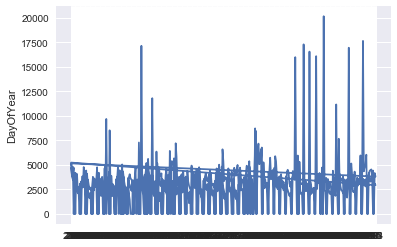

In [87]:
#print(train_store_labels)
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_store['DayOfYear'], train_store_labels)
plt.ylabel('Sales')
plt.ylabel('DayOfYear')
plt.show()

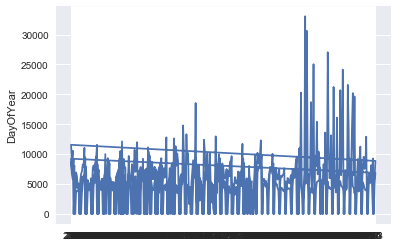

In [93]:
#先选取一家店来做训练
train_store1 = train[train['Store'] == 126]
# 提取标签
train_store1_labels = train_store1['Sales']

plt.plot(train_store1['DayOfYear'], train_store1_labels)
plt.ylabel('Sales')
plt.ylabel('DayOfYear')
plt.show()

In [80]:
for idx, s in enumerate(scores):
    if (s < 0.8):
        print(idx + 1, s)

103 0.7937063723439266
106 0.7978844273730487
126 0.4752565741125837
227 0.7635620471599657
232 0.6629286245692376
292 0.7658592721020419
303 0.6876713398170092
348 0.5059244178210399
423 0.5967801843183225
512 0.7562354414160637
548 0.7801335065641313
562 0.770663917428171
733 0.39029450136832944
769 0.6086902365015723
803 0.7898558861445026
897 0.25269565172780206
948 0.7970177791965185
956 0.7959407804445418
1045 0.7972206532425031
1097 0.7020543855295294
